In [54]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

from scipy.integrate import simps
from scipy.interpolate import interp1d

from opcoes.simulation import generate_paths

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

In [159]:
# fetch index daily returns
DATA_PATH = './asset_data.csv'
df = pd.read_csv(DATA_PATH)
# set Date as dt format and index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['SPX']]
df.tail()

,SPX
Date,
2021-09-30,4307.540039
2021-10-01,4357.040039
2021-10-03,NaN
2021-10-04,4300.459961
2021-10-05,NaN


In [160]:
# set year column
df['Year'] = df.index.year
df['Month'] = df.index.to_period('M')
# fwd fill na values
df['SPX'] = df['SPX'].ffill()

In [171]:
stats.kurtosis((np.log(df['SPX'] / df['SPX'].shift(66))).dropna())

8.921352846416866

In [166]:
df

,SPX,Year,Month,ret
Date,,,,
1927-12-30,17.660000,1927,1927-12,NaN
1928-01-03,17.760000,1928,1928-01,0.005647
1928-01-04,17.719999,1928,1928-01,-0.002255
1928-01-05,17.549999,1928,1928-01,-0.009640
1928-01-09,17.500000,1928,1928-01,-0.002853
...,...,...,...,...
2021-09-30,4307.540039,2021,2021-09,-0.011981
2021-10-01,4357.040039,2021,2021-10,0.011426
2021-10-03,4357.040039,2021,2021-10,0.000000


In [162]:
df_ann_end_pxs = df.groupby('Year').last()
df_ann_rets = np.log(df_end_pxs / df_end_pxs.shift(1)).dropna()

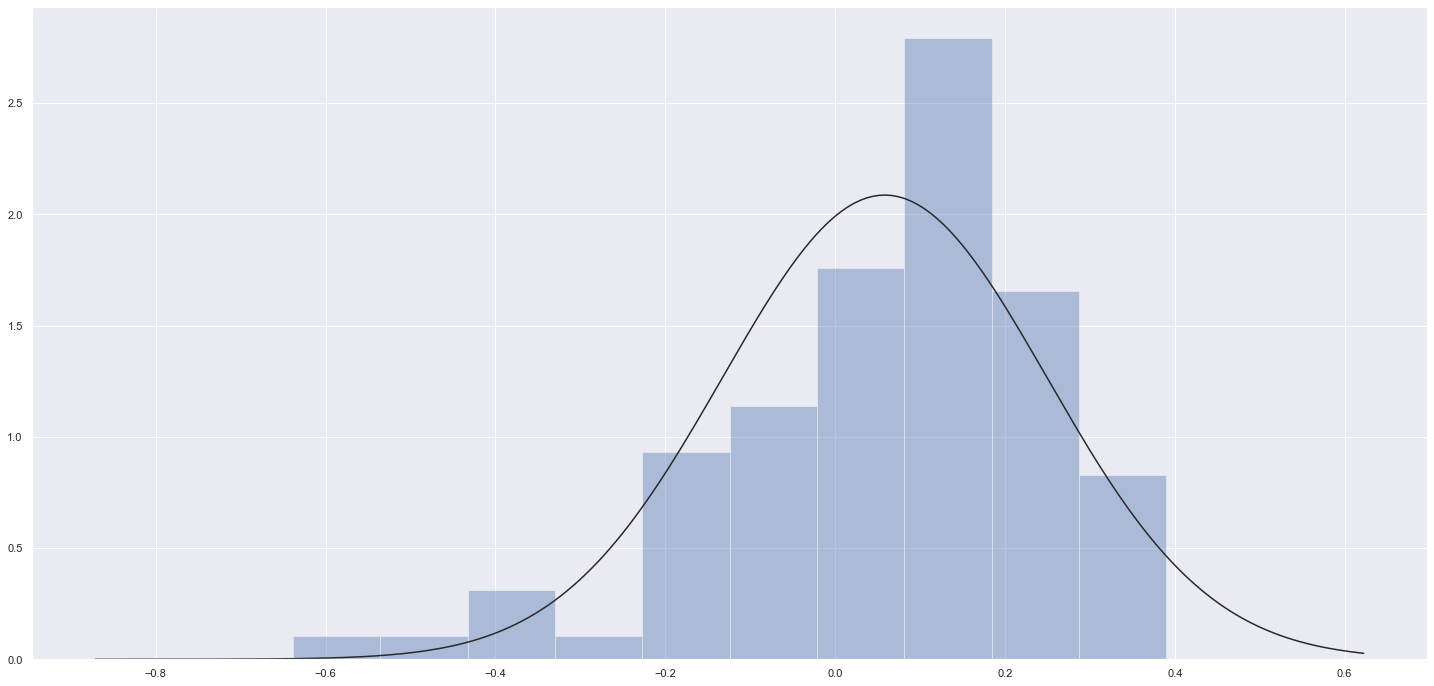

In [128]:
# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(df_ann_rets, kde=False, norm_hist=True, fit=stats.norm, ax=ax);

In [129]:
df_mon_end_pxs = df.groupby('Month').last()
df_mon_rets = np.log(df_mon_end_pxs / df_mon_end_pxs.shift(1)).dropna()

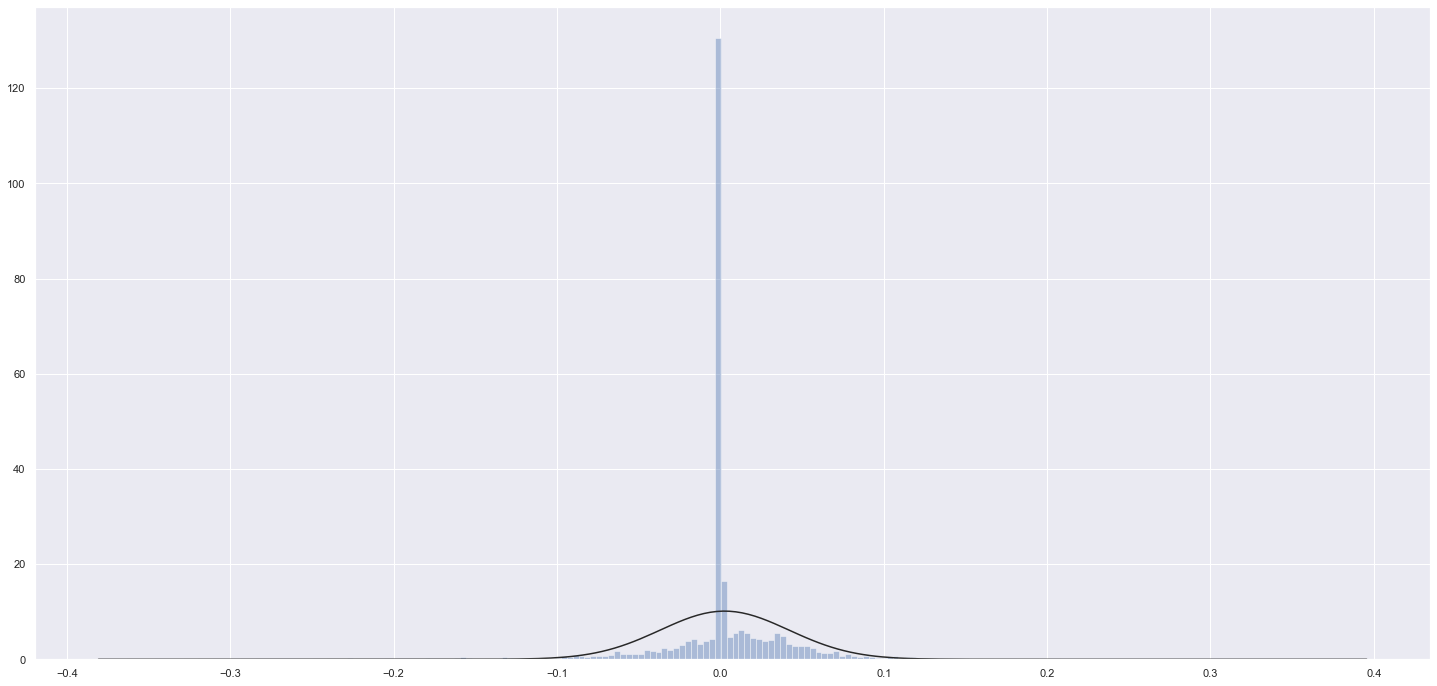

In [141]:
# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(df_mon_rets, kde=False, norm_hist=True, fit=stats.norm, ax=ax, bins=200);

In [131]:
df_rets = np.log(df['SPX'] / df['SPX'].shift(1)).dropna()

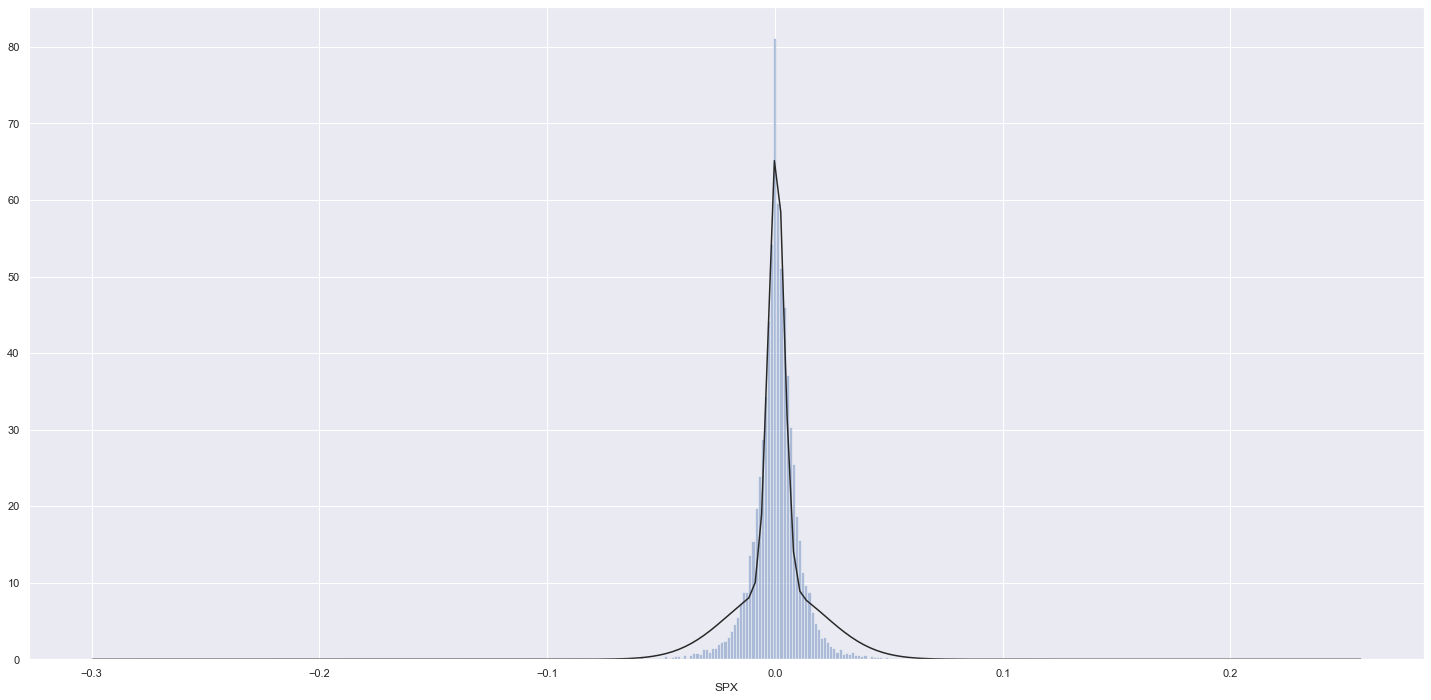

In [146]:
# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(df_rets, kde=False, norm_hist=True, fit=cust_dist(e=0.95), ax=ax, bins=400);

In [149]:
cust_dist(e=0.95).fit(df_rets)

(0.0005914899997543878, 0.015473597860658217)

In [152]:
(np.var(rets_cust[:,1]) * 250)**0.5

0.20012608622556247

In [155]:
stats.kurtosis(rets_cust[:,1])

2.7270736296927964

In [55]:
# define our gaussian look-a-like distribution
class cust_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # init our variance divergence
        self.e = e
        # init our cdf and ppf functions
        self.cdf_func, self.ppf_func = self.create_cdf_ppf()
        
    # function to return normal distribution pdf
    def norm_p(self, x, loc=0, scale=1):
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
        
    # function to normalise the pdf over chosen domain
    def normalisation(self, x):
        return simps(self.pdf(x), x)
    
    # function to
    def create_cdf_ppf(self):
        # define domain as +/-25 sigma
        xs = np.linspace(-25, 25, 10000001)
        # normalise our pdf to sum to 1 so it satisfies a distribution
        norm_constant = self.normalisation(xs)
        # compute pdfs to be summed to form cdf
        my_pdfs = self.pdf(xs) / norm_constant
        # cumsum to form cdf
        my_cdf = np.cumsum(my_pdfs)
        # make sure cdf bounded on [0,1]
        my_cdf = my_cdf / my_cdf[-1]
        # create cdf and ppf
        func_cdf = interp1d(xs, my_cdf)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
        
    # pdf function for averaged normals
    def _pdf(self, x):
        # define lower var distribution prob
        low = self.norm_p(x, scale=(1 - self.e)**0.5)
        # define higher var distribution prob
        high = self.norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    # cdf function
    def _cdf(self, x):
        return self.cdf_func(x)
    
    # inverse cdf function
    def _ppf(self, x):
        return self.ppf_func(x)

In [56]:
rng = np.random.default_rng(seed=123)
dist = cust_dist(e=0.8, seed=rng)

In [65]:
def generate_paths_cust(spot, drift, sigma, years, points, sims):

    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # init dist class
    dist = cust_dist(e=0.95, seed=rng)
    # create random numbers
    dW = dist.rvs(size=(sims, int(points * years)))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    # return the goodies
    return daily_devs, pxs

In [66]:
s = 100
drift = 0.05
sigma = 0.20
years = 1
points = 250
sims = 10000

rets_cust, pxs_cust = generate_paths_cust(s, drift, sigma, years, points, sims)
rets, pxs = generate_paths(s, drift, sigma, years, points, sims)

<AxesSubplot:>

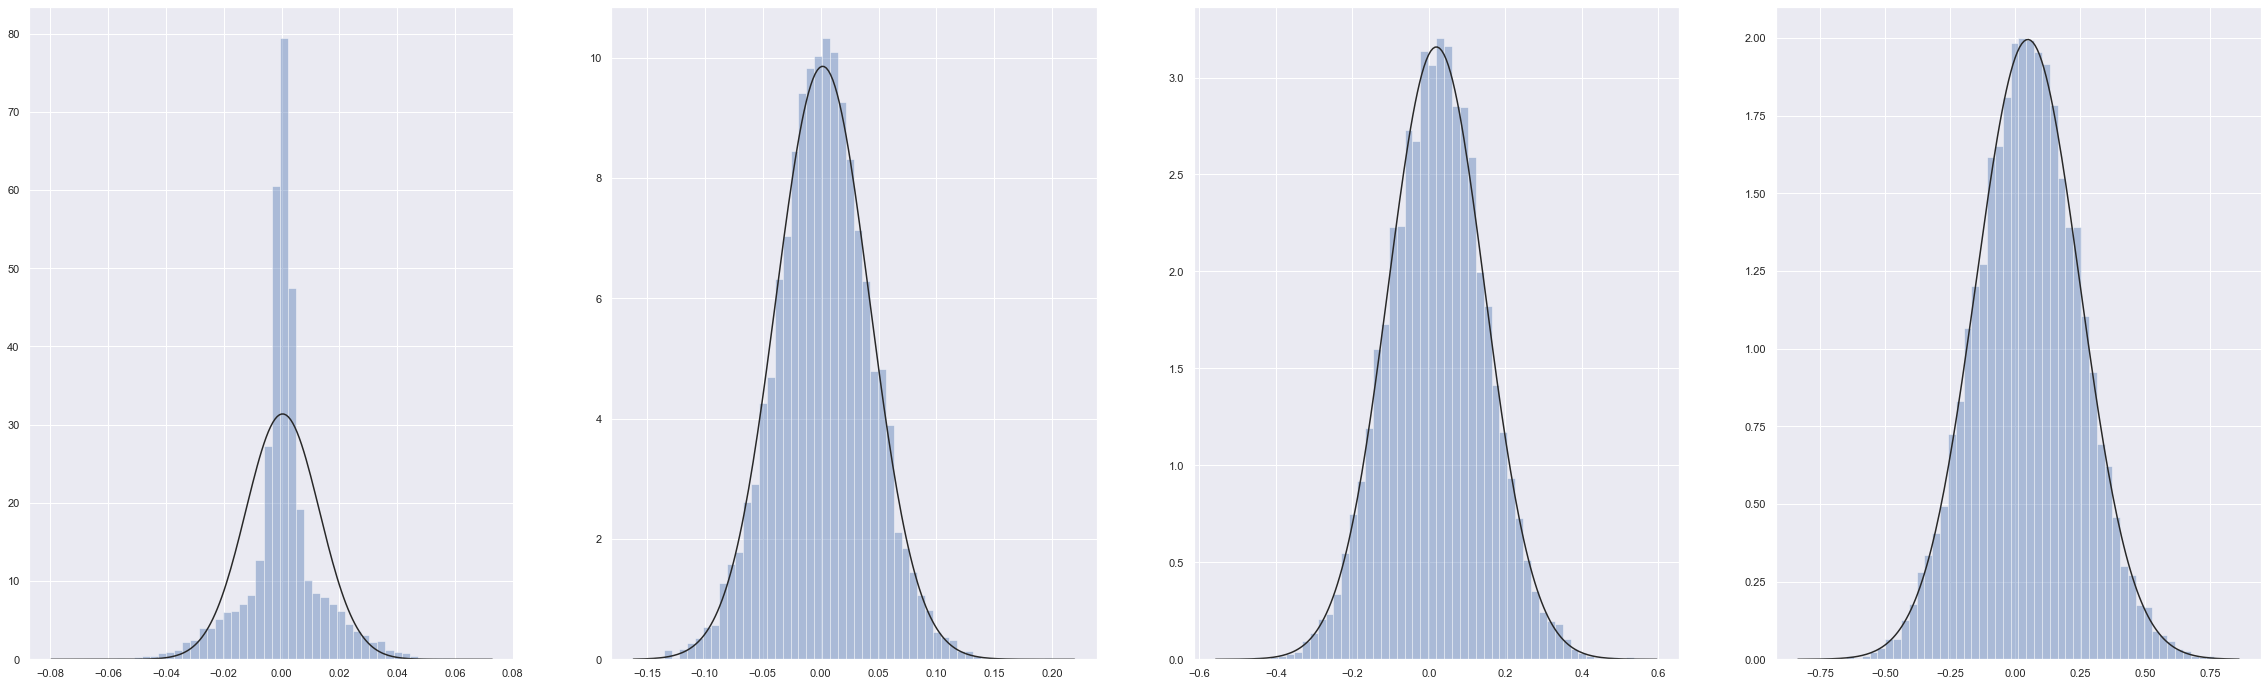

In [74]:
# plot them
fig, axes = plt.subplots(ncols=4, figsize=(40,12))
axes = axes.reshape(-1)

# plot hist and pdf to see if they aline
sns.distplot(np.log(pxs_cust[:,1]/100), kde=False, norm_hist=True, fit=stats.norm, ax=axes[0])
sns.distplot(np.log(pxs_cust[:,10]/100), kde=False, norm_hist=True, fit=stats.norm, ax=axes[1])
sns.distplot(np.log(pxs_cust[:,100]/100), kde=False, norm_hist=True, fit=stats.norm, ax=axes[2])
sns.distplot(np.log(pxs_cust[:,-1]/100), kde=False, norm_hist=True, fit=stats.norm, ax=axes[3])

<AxesSubplot:>

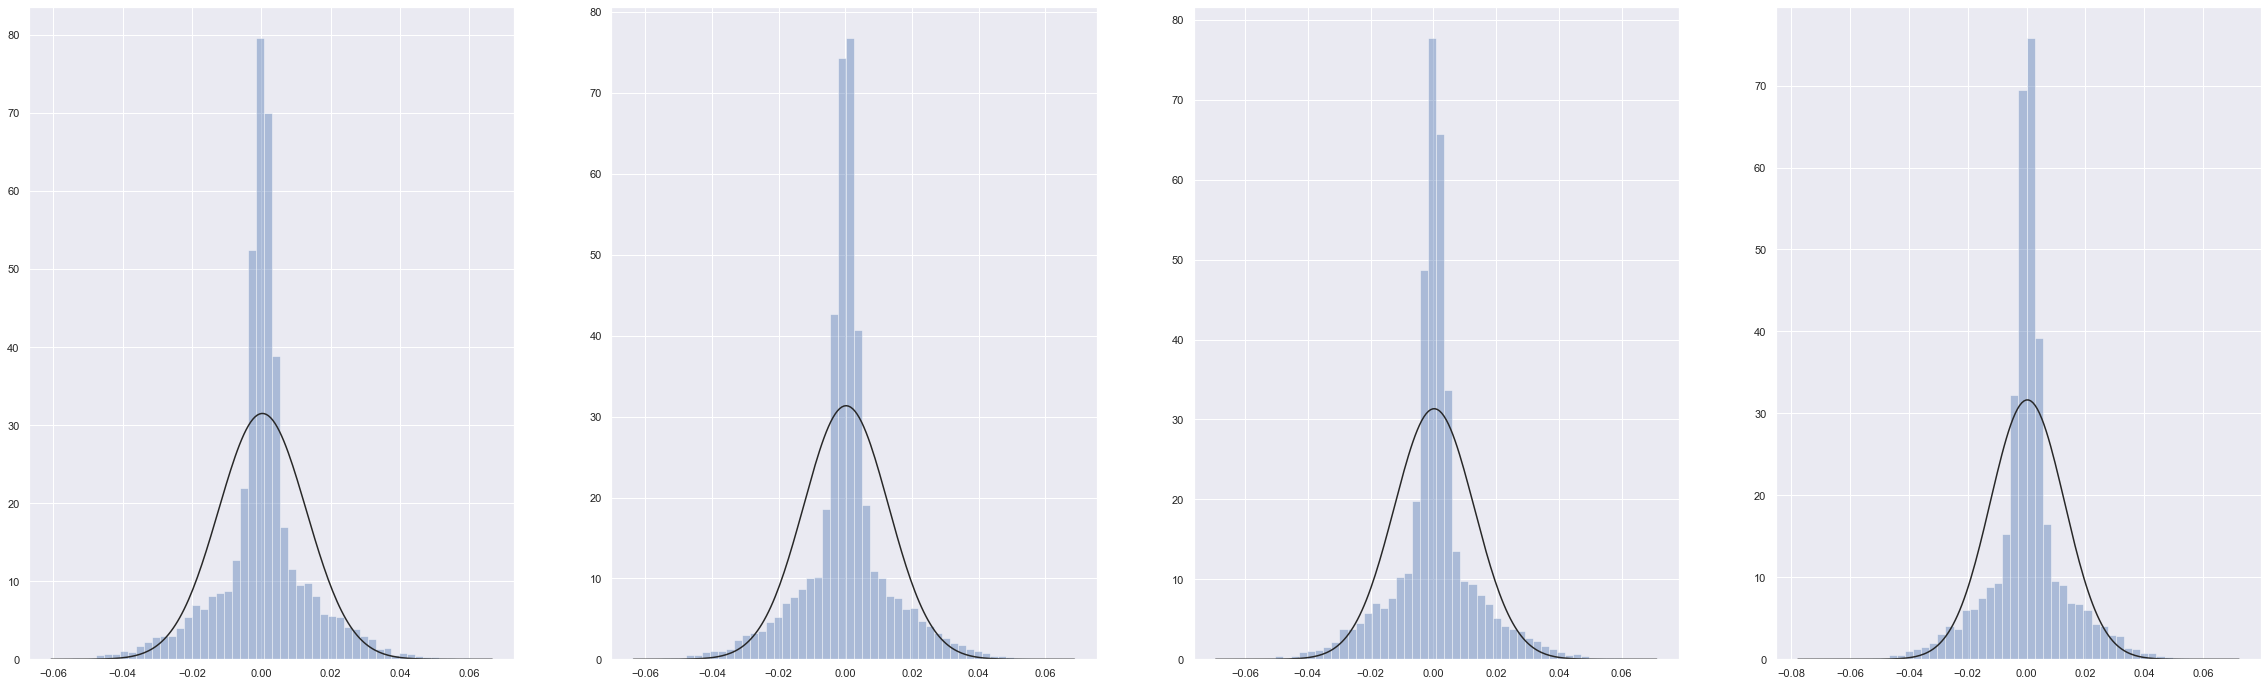

In [76]:
# plot them
fig, axes = plt.subplots(ncols=4, figsize=(40,12))
axes = axes.reshape(-1)

# plot hist and pdf to see if they aline
sns.distplot(rets_cust[:,1], kde=False, norm_hist=True, fit=stats.norm, ax=axes[0])
sns.distplot(rets_cust[:,10], kde=False, norm_hist=True, fit=stats.norm, ax=axes[1])
sns.distplot(rets_cust[:,100], kde=False, norm_hist=True, fit=stats.norm, ax=axes[2])
sns.distplot(rets_cust[:,-1], kde=False, norm_hist=True, fit=stats.norm, ax=axes[3])

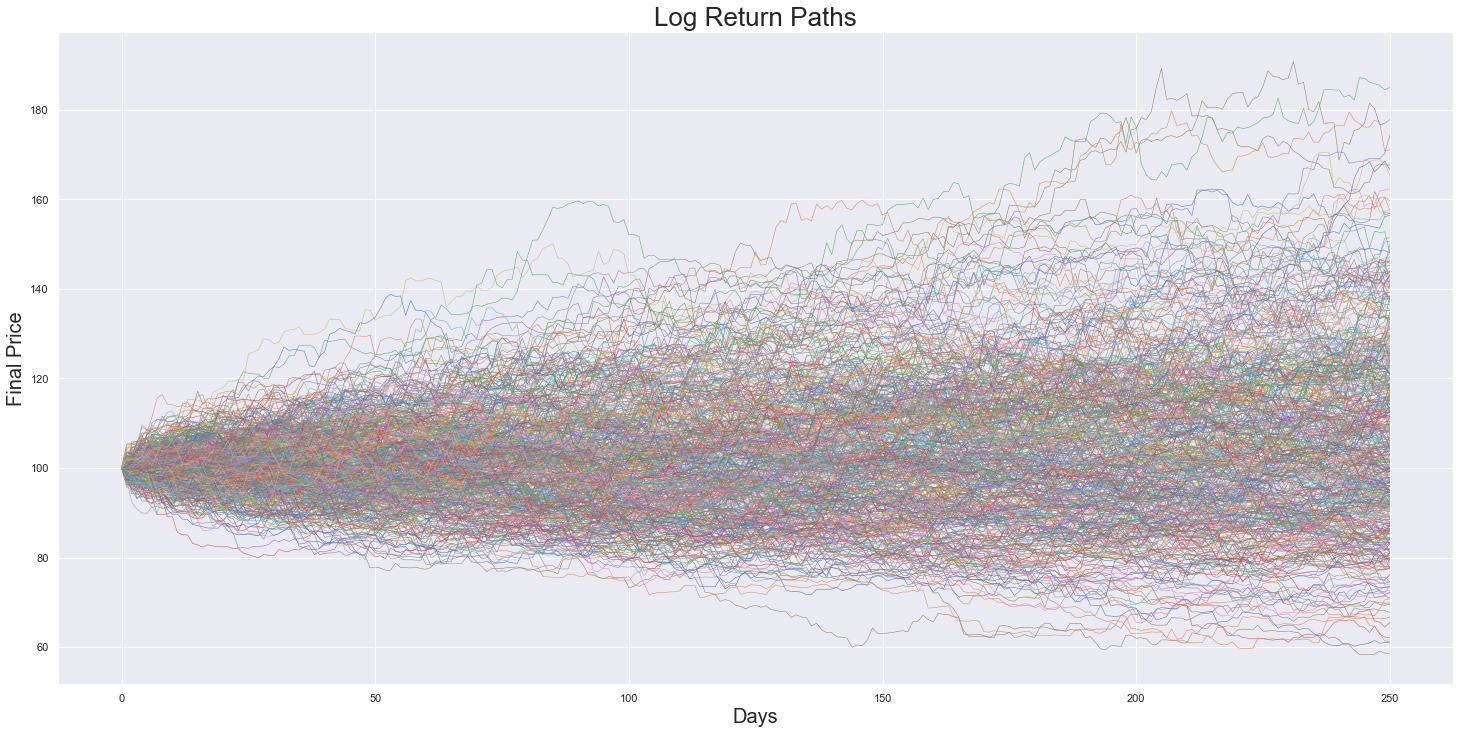

In [67]:
# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs_cust[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

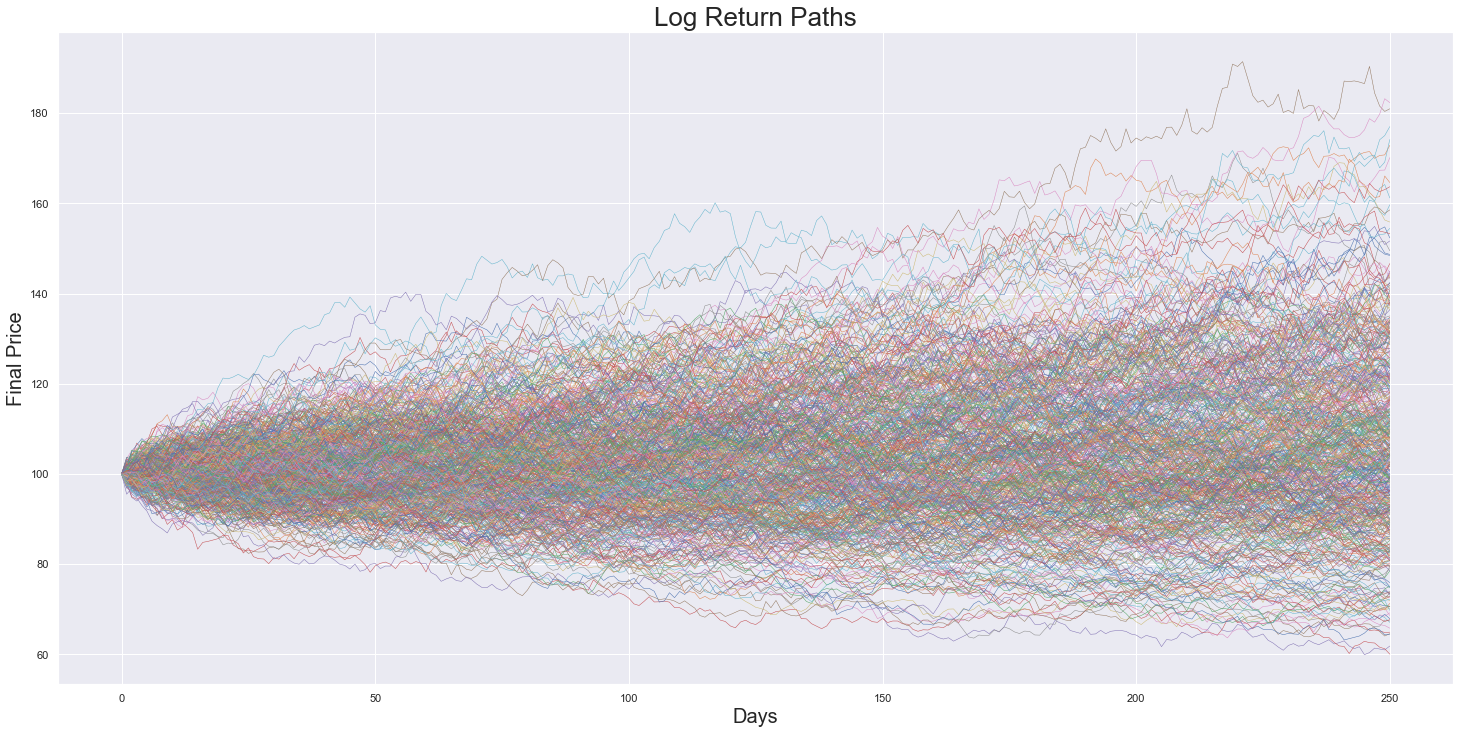

In [68]:
# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

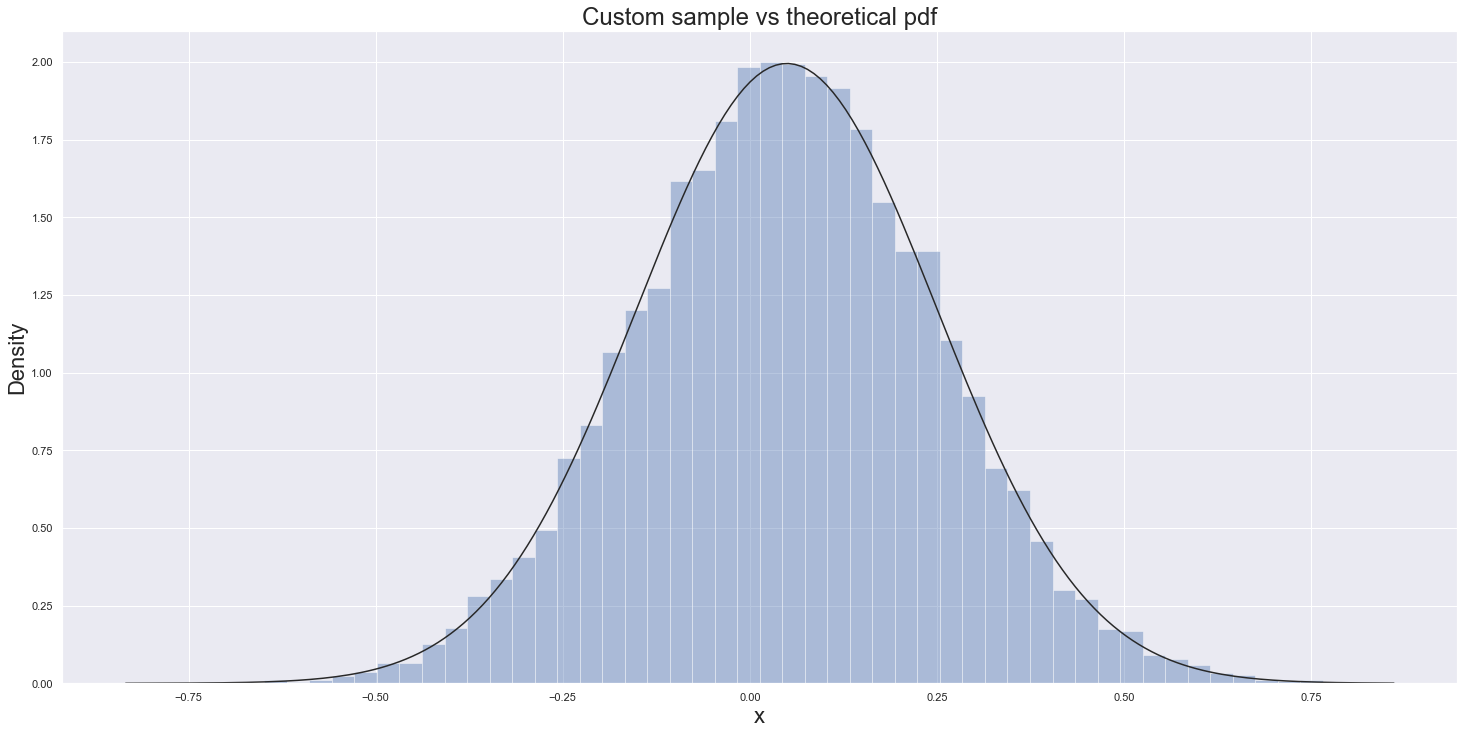

In [69]:
# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

# plot hist and pdf to see if they aline
sns.distplot(np.log(pxs_cust[:,-1]/100), label='naive_samps', kde=False, norm_hist=True, fit=stats.norm, ax=ax)
# label
ax.set_title('Custom sample vs theoretical pdf', fontsize=24)
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('Density', fontsize=22);

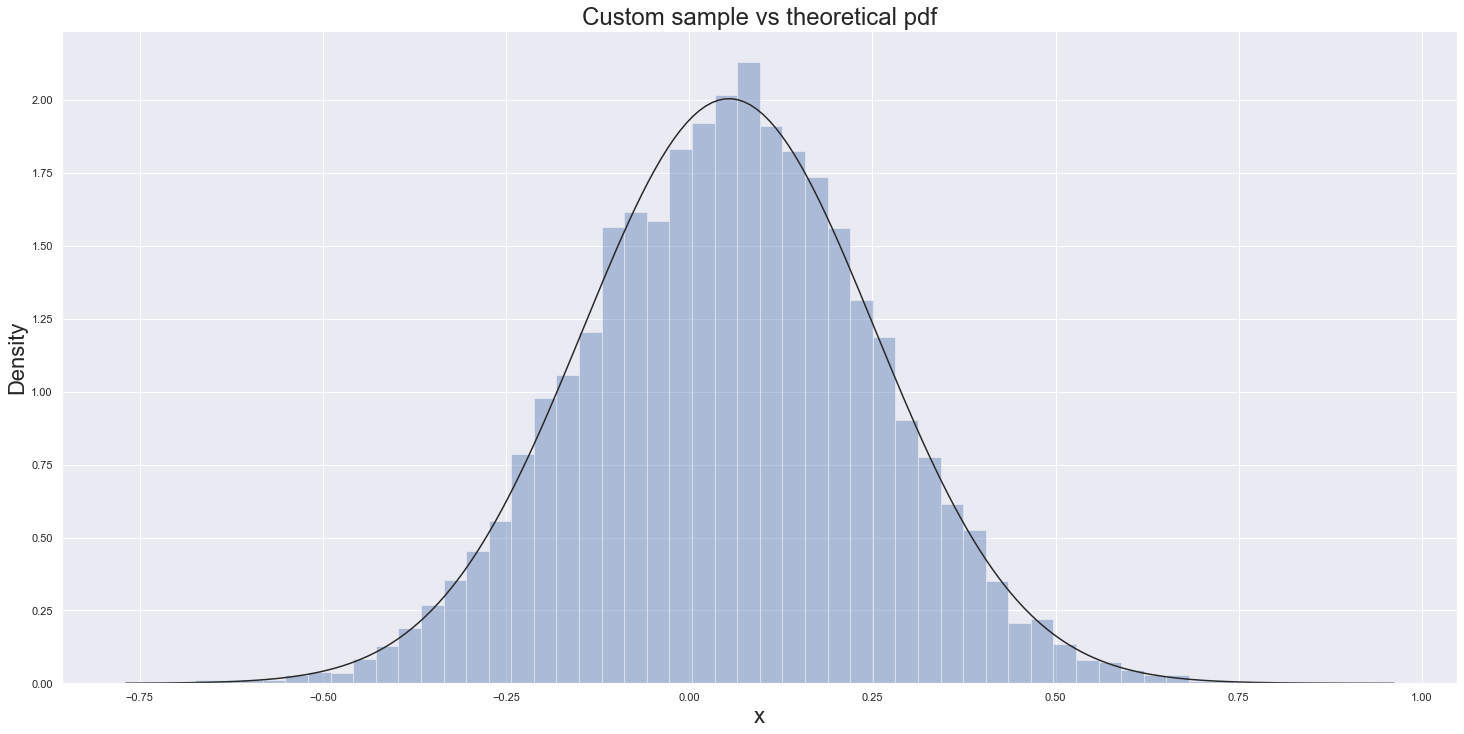

In [70]:
# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

# plot hist and pdf to see if they aline
sns.distplot(np.log(pxs[:,-1]/100), label='naive_samps', kde=False, norm_hist=True, fit=stats.norm, ax=ax)
# label
ax.set_title('Custom sample vs theoretical pdf', fontsize=24)
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('Density', fontsize=22);

In [50]:
stats.norm.fit(np.log(pxs[:,-1]/100))

(0.04917861243305369, 0.1996316555158563)

In [51]:
np.std(np.log(pxs[:,-1]/100))

0.1996316555158563

In [52]:
stats.kurtosis(np.log(pxs[:,-1]/100))

-0.03367032144752047

In [53]:
stats.skew(np.log(pxs[:,-1]/100))

0.06754943169802874